stackingのアンサンブル用シート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.linear_model import LinearRegression
import xgboost
from sklearn.model_selection import KFold

###訓練データの読み込み
house_age = pd.read_csv('house_age.csv')
area_size = pd.read_csv('area_size.csv')
room_arrange = pd.read_csv('room_arrange.csv')
contract_span = pd.read_csv('contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('reg_rent.csv')
floor_scores = pd.read_csv('floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('stations.csv')
minits = pd.read_csv('minits.csv')
addresses = pd.read_csv('addresses.csv')
room_arrange = pd.read_csv('room_arrange.csv')
buildings = pd.read_csv('buildings.csv')

rent = pd.read_csv('rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('test_house_age.csv')
test_area_size = pd.read_csv('test_area_size.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_contract_span = pd.read_csv('test_contract_span.csv')
test_contract_span2 = pd.read_csv('test_contract_span2.csv')
test_reg_rent = pd.read_csv('test_reg_rent.csv')
test_floor_scores = pd.read_csv('test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('test_capital_floor_scores2.csv')
test_stations = pd.read_csv('test_stations.csv')
test_minits = pd.read_csv('test_minits.csv')
test_addresses = pd.read_csv('test_addresses.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_buildings = pd.read_csv('test_buildings.csv')

Duplicate key in file PosixPath('/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family : IPAexGothic')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


lightGBMとDARTとGOSSとXGBoostでstackingアンサンブルを行う。

In [2]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange[["部屋数","L","D","K","S"]]], axis=1)
y_train = rent
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange[["部屋数","L","D","K","S"]]], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
sX_train, sX_valid, sy_train, sy_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [3]:
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K','S']

####LisgtGBM###
lgb_train = lgb.Dataset(sX_train, sy_train)
lgb_eval = lgb.Dataset(sX_valid, sy_valid, reference=lgb_train)
params_LGBM = {
    'objective':'regression',
    'metrics':'rmse',
    'learning_rate':0.05,
    'reg_lambda': 4.430375245218262e-06,
    'max_bin': 502,
    'num_leaves': 97
}
model_LGBM = lgb.train(
                    params_LGBM,
                    lgb_train, 
                    valid_sets=[lgb_train, lgb_eval], 
                    verbose_eval=10, 
                    num_boost_round=3000, 
                    early_stopping_rounds=10,
                    categorical_feature = category_lists
                    )

###DART###
lgb_train = lgb.Dataset(sX_train, sy_train)
lgb_eval = lgb.Dataset(sX_valid, sy_valid, reference=lgb_train)
params_DART = {
    'objective':'regression',
    'boosting_type':'dart',
    'metrics':'rmse',
    'learning_rate':0.05,
    'reg_lambda': 2.1600820741402023e-05,
    'max_bin': 556,
    'num_leaves': 126
}

model_DART = lgb.train(
                    params_DART,
                    lgb_train, 
                    valid_sets=[lgb_train, lgb_eval], 
                    verbose_eval=10, 
                    num_boost_round=1000, 
                    early_stopping_rounds=10,
                    categorical_feature = category_lists
                    )

###GOSS###
lgb_train = lgb.Dataset(sX_train, sy_train)
lgb_eval = lgb.Dataset(sX_valid, sy_valid, reference=lgb_train)
params_GOSS = {
    'objective':'regression',
    'boosting_type':'goss',
    'metrics':'rmse',
    'learning_rate':0.05,
    'reg_lambda': 4.669226029558975e-07,
    'max_bin': 584,
    'num_leaves': 85
}

model_GOSS = lgb.train(
                    params_GOSS,
                    lgb_train, 
                    valid_sets=[lgb_train, lgb_eval], 
                    verbose_eval=10, 
                    num_boost_round=1000, 
                    early_stopping_rounds=10,
                    categorical_feature = category_lists
                    )

###XGBoost###
xgb_reg = xgboost.XGBRegressor(
    #目的関数の指定 初期値も二乗誤差です
                    objective='reg:linear',
                    #学習のラウンド数 early_stoppingを利用するので多めに指定
                    n_estimators=50000,
                    #boosterに何を用いるか 初期値もgbtreeです
                    booster='gbtree',
                    learning_rate=0.05,
                    max_depth=7,
                    random_state=0,
                    reg_alfa=2.054762512591133e-06,
                    sub_sample=0.5530198332197337,
                    colsample_bytree=0.7642417009494488,
                    min_child_weight=0.14135935551752302
)
xgb_reg.fit(sX_train, sy_train, eval_set=[(sX_valid, sy_valid)], early_stopping_rounds=10)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 22658, number of used features: 14
[LightGBM] [Info] Start training from score 118575.175126
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50511.5	valid_1's rmse: 47173.3
[20]	training's rmse: 36554.8	valid_1's rmse: 34357.2
[30]	training's rmse: 27718.5	valid_1's rmse: 27678.9
[40]	training's rmse: 21895.7	valid_1's rmse: 23455.8
[50]	training's rmse: 18480.9	valid_1's rmse: 21216
[60]	training's rmse: 16201.8	valid_1's rmse: 19959.1
[70]	training's rmse: 14759.3	valid_1's rmse: 19144.7
[80]	training's rmse: 13748	valid_1's rmse: 18632.3
[90]	training's rmse: 13001.9	valid_1's rmse: 18250.1
[100]	training's rmse: 12406.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[20]	training's rmse: 39060.6	valid_1's rmse: 38386.1
[30]	training's rmse: 31370.9	valid_1's rmse: 32300.4
[40]	training's rmse: 28097.6	valid_1's rmse: 30064.5
[50]	training's rmse: 31488.4	valid_1's rmse: 33271.2
[60]	training's rmse: 35739.4	valid_1's rmse: 37504.2
[70]	training's rmse: 37646.7	valid_1's rmse: 39294.6
[80]	training's rmse: 32693.3	valid_1's rmse: 34700.5
[90]	training's rmse: 32554.9	valid_1's rmse: 34409.7
[100]	training's rmse: 34533.3	valid_1's rmse: 36461.8
[110]	training's rmse: 41327.6	valid_1's rmse: 42712
[120]	training's rmse: 33168.8	valid_1's rmse: 35604.5
[130]	training's rmse: 30080.5	valid_1's rmse: 32858.9
[140]	training's rmse: 32758.2	valid_1's rmse: 35347.7
[150]	training's rmse: 31275.1	valid_1's rmse: 33906.6
[160]	training's rmse: 35974.8	valid_1's rmse: 38104.3
[170]	training's rmse: 29090.7	valid_1's rmse: 32068.1
[180]	training's rmse: 27767.1	valid_1's rmse: 31113.5
[190]	training's rmse: 23772.2	valid_1's rmse: 27726.5
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-rmse:68785.59039
[16]	validation_0-rmse:66023.10751
[17]	validation_0-rmse:63305.05193
[18]	validation_0-rmse:60876.61611
[19]	validation_0-rmse:58440.02378
[20]	validation_0-rmse:56526.74184
[21]	validation_0-rmse:54541.82777
[22]	validation_0-rmse:52925.30037
[23]	validation_0-rmse:51141.56174
[24]	validation_0-rmse:49636.51780
[25]	validation_0-rmse:48034.42951
[26]	validation_0-rmse:46578.44929
[27]	validation_0-rmse:45363.79701
[28]	validation_0-rmse:44017.63525
[29]	validation_0-rmse:42952.96790
[30]	validation_0-rmse:41787.19960
[31]	validation_0-rmse:40922.97690
[32]	validation_0-rmse:40116.82153
[33]	validation_0-rmse:39010.35724
[34]	validation_0-rmse:38065.92642
[35]	validation_0-rmse:37371.72353
[36]	validation_0-rmse:36730.88944
[37]	validation_0-rmse:36004.77936
[38]	validation_0-rmse:35466.79956
[39]	validation_0-rmse:34968.01568
[40]	validation_0-rmse:34527.49734
[41]	validation_0-rmse:34083.33354
[42]	validation_0-rmse:33663.22061
[43]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7642417009494488, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=7, max_leaves=0,
             min_child_weight=0.14135935551752302, missing=nan,
             monotone_constraints='()', n_estimators=50000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alfa=2.054762512591133e-06, ...)

ブレンドのモデルが重回帰分析の場合

In [31]:
# 個別のモデルの予測値たち。
valid_pred_LGBM = model_LGBM.predict(X_valid)
# valid_pred_DART = model_DART.predict(X_valid)
valid_pred_GOSS = model_GOSS.predict(X_valid)
valid_pred_XGB = xgb_reg.predict(X_valid)

# ブレンドの特徴量になるものをまとめる。
# stack_valid_pred = np.column_stack((valid_pred_LGBM,valid_pred_LGBM,valid_pred_GOSS,valid_pred_XGB))
stack_valid_pred = np.column_stack((valid_pred_LGBM,valid_pred_GOSS,valid_pred_XGB))

# ブレンドの作成。
blend_model = LinearRegression()
# ブレンドの特徴量として作ったデータと元データのy_validでブレンドを学習させる。
blend_model.fit(stack_valid_pred, y_valid)

# ここのモデルによるテストデータからの予測値
pred_LGBM = model_LGBM.predict(X_test)
# pred_DART = model_DART.predict(X_test)
pred_GOSS = model_GOSS.predict(X_test)
pred_XGB = xgb_reg.predict(X_test)

pred_LGBM = pd.DataFrame(pred_LGBM)
# pred_DART = pd.DataFrame(pred_DART)
pred_GOSS = pd.DataFrame(pred_GOSS)
pred_XGB = pd.DataFrame(pred_XGB)

#　ブレンドモデルのテストデータを作成
# stack_test_pred = np.column_stack((pred_LGBM, pred_DART, pred_GOSS, pred_XGB))
stack_test_pred = np.column_stack((pred_LGBM, pred_GOSS, pred_XGB))
print(stack_test_pred)

blend_pred = blend_model.predict(stack_test_pred)
blend_pred = pd.DataFrame(blend_pred)

[[138580.03774219 131631.84568007 118002.78125   ]
 [121670.7329273  121447.10733973 119678.2734375 ]
 [ 81581.16831512  83961.93487889  84770.125     ]
 ...
 [177533.51012032 174722.01942288 172593.78125   ]
 [264934.83305639 258337.94436019 277411.        ]
 [ 84175.95815483  82119.23128678  82911.5       ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


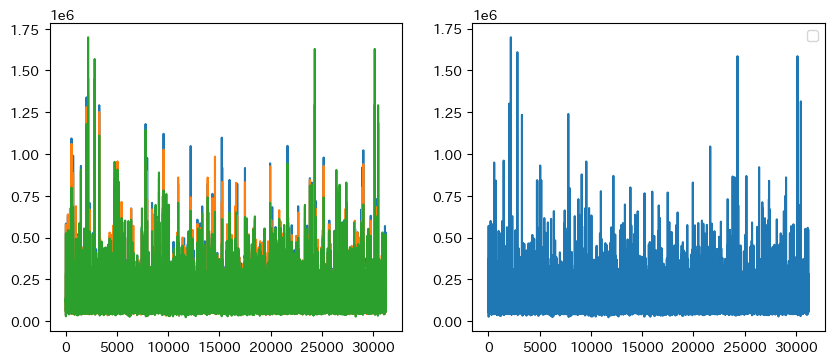

In [32]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(range(len(blend_pred)), pred_LGBM, label='LGBM')
# ax.plot(range(len(blend_pred)), pred_DART, label='DART')
ax.plot(range(len(blend_pred)), pred_GOSS, label='GOSS')
ax.plot(range(len(blend_pred)), pred_XGB, label='XGB')

ax2.plot(range(len(blend_pred)), blend_pred)

plt.legend(loc='best')
plt.show()

ブレンドのモデルがLGBMの場合

In [3]:
# 個別のモデルの予測値たち。
valid_pred_LGBM = model_LGBM.predict(X_valid)
# valid_pred_DART = model_DART.predict(X_valid)
valid_pred_GOSS = model_GOSS.predict(X_valid)
valid_pred_XGB = xgb_reg.predict(X_valid)

# ブレンドの特徴量になるものをまとめる。
# stack_valid_pred = np.column_stack((valid_pred_LGBM,valid_pred_DART,valid_pred_GOSS,valid_pred_XGB))
stack_valid_pred = np.column_stack((valid_pred_LGBM,valid_pred_GOSS,valid_pred_XGB))

# ブレンドの作成。
blend_model = lgb.LGBMRegressor()
# ブレンドの特徴量として作ったデータと元データのy_validでブレンドを学習させる。
blend_model.fit(stack_valid_pred, y_valid)

# ここのモデルによるテストデータからの予測値
pred_LGBM = model_LGBM.predict(X_test)
# pred_DART = model_DART.predict(X_test)
pred_GOSS = model_GOSS.predict(X_test)
pred_XGB = xgb_reg.predict(X_test)

pred_LGBM = pd.DataFrame(pred_LGBM)
# pred_DART = pd.DataFrame(pred_DART)
pred_GOSS = pd.DataFrame(pred_GOSS)
pred_XGB = pd.DataFrame(pred_XGB)

#　ブレンドモデルのテストデータを作成
# stack_test_pred = np.column_stack((pred_LGBM, pred_DART, pred_GOSS, pred_XGB))
stack_test_pred = np.column_stack((pred_LGBM, pred_GOSS, pred_XGB))
print(stack_test_pred)

blend_pred = blend_model.predict(stack_test_pred)
blend_pred = pd.DataFrame(blend_pred)

NameError: name 'model_LGBM' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


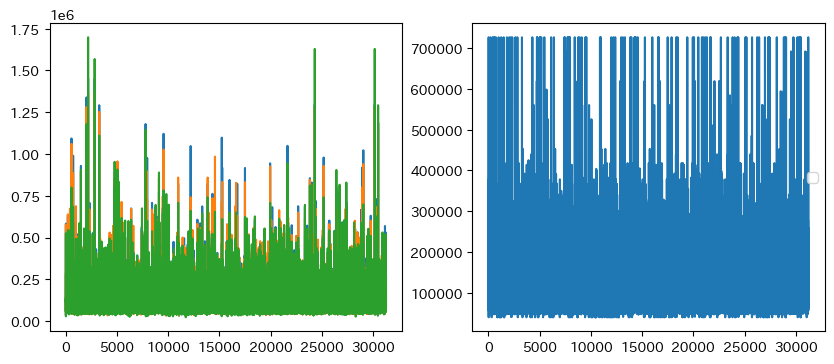

In [27]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(range(len(blend_pred)), pred_LGBM, label='LGBM')
# ax.plot(range(len(blend_pred)), pred_DART, label='DART')
ax.plot(range(len(blend_pred)), pred_GOSS, label='GOSS')
ax.plot(range(len(blend_pred)), pred_XGB, label='XGB')

ax2.plot(range(len(blend_pred)), blend_pred)

plt.legend(loc='best')
plt.show()

ファイル出力

In [36]:
df = pd.read_csv('test.csv')
id = df['id']
y_pred = pd.DataFrame(blend_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('blend_result.csv',index=False)

lightGBMとDARTとGOSSとXGBoostでstackingアンサンブルを行う。(交差検証ver)

In [8]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange[["部屋数","L","D","K","S"]]], axis=1)
y_train = rent
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange[["部屋数","L","D","K","S"]]], axis=1)

#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# sX_train, sX_valid, sy_train, sy_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [9]:
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K','S']

cv = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]
    sX_tr, sX_val, sy_tr, sy_val = train_test_split(X_tr, y_tr, test_size=0.1, random_state=0)

    ####LisgtGBM###
    lgb_train = lgb.Dataset(sX_tr, sy_tr)
    lgb_eval = lgb.Dataset(sX_val, sy_val, reference=lgb_train)
    params_LGBM = {
        'objective':'regression',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 4.430375245218262e-06,
        'max_bin': 502,
        'num_leaves': 97
    }
    model_LGBM = lgb.train(
                        params_LGBM,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=3000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

    ###DART###
    lgb_train = lgb.Dataset(sX_tr, sy_tr)
    lgb_eval = lgb.Dataset(sX_val, sy_val, reference=lgb_train)
    params_DART = {
        'objective':'regression',
        'boosting_type':'dart',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 2.1600820741402023e-05,
        'max_bin': 556,
        'num_leaves': 126
    }

    model_DART = lgb.train(
                        params_DART,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=2000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

    ###GOSS###
    lgb_train = lgb.Dataset(sX_tr, sy_tr)
    lgb_eval = lgb.Dataset(sX_val, sy_val, reference=lgb_train)
    params_GOSS = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 4.669226029558975e-07,
        'max_bin': 584,
        'num_leaves': 85
    }

    model_GOSS = lgb.train(
                        params_GOSS,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

    ###XGBoost###
    xgb_reg = xgboost.XGBRegressor(
        #目的関数の指定 初期値も二乗誤差です
                        objective='reg:linear',
                        #学習のラウンド数 early_stoppingを利用するので多めに指定
                        n_estimators=50000,
                        #boosterに何を用いるか 初期値もgbtreeです
                        booster='gbtree',
                        learning_rate=0.05,
                        max_depth=7,
                        random_state=0,
                        reg_alfa=2.054762512591133e-06,
                        sub_sample=0.5530198332197337,
                        colsample_bytree=0.7642417009494488,
                        min_child_weight=0.14135935551752302
    )
    xgb_reg.fit(sX_tr, sy_tr, eval_set=[(sX_val, sy_val)], early_stopping_rounds=10)

_, X_valid, _, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# 個別のモデルの予測値たち。
valid_pred_LGBM = model_LGBM.predict(X_valid)
valid_pred_DART = model_DART.predict(X_valid)
valid_pred_GOSS = model_GOSS.predict(X_valid)
valid_pred_XGB = xgb_reg.predict(X_valid)

# ブレンドの特徴量になるものをまとめる。
stack_valid_pred = np.column_stack((valid_pred_LGBM,valid_pred_DART,valid_pred_GOSS,valid_pred_XGB))

# ブレンドの作成。
blend_model = RandomForestRegressor()

# ブレンドの特徴量として作ったデータと元データのy_validでブレンドを学習させる。
blend_model.fit(stack_valid_pred, y_valid)

# ここのモデルによるテストデータからの予測値
pred_LGBM = model_LGBM.predict(X_test)
pred_DART = model_DART.predict(X_test)
pred_GOSS = model_GOSS.predict(X_test)
pred_XGB = xgb_reg.predict(X_test)

pred_LGBM = pd.DataFrame(pred_LGBM)
pred_DART = pd.DataFrame(pred_DART)
pred_GOSS = pd.DataFrame(pred_GOSS)
pred_XGB = pd.DataFrame(pred_XGB)

#　ブレンドモデルのテストデータを作成
stack_test_pred = np.column_stack((pred_LGBM, pred_DART, pred_GOSS, pred_XGB))
print("ブレンドモデルに入れるテストデータ",stack_test_pred)

#ブレンドモデルによる最終の予測値
blend_pred = blend_model.predict(stack_test_pred)
blend_pred = pd.DataFrame(blend_pred)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 22658, number of used features: 14
[LightGBM] [Info] Start training from score 118553.622032
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50328	valid_1's rmse: 47240
[20]	training's rmse: 35797.3	valid_1's rmse: 34001.6
[30]	training's rmse: 26774	valid_1's rmse: 26849.9
[40]	training's rmse: 21130.3	valid_1's rmse: 22299.8
[50]	training's rmse: 17778.9	valid_1's rmse: 20033
[60]	training's rmse: 15623.4	valid_1's rmse: 18753.8
[70]	training's rmse: 14230.2	valid_1's rmse: 18066.9
[80]	training's rmse: 13242.3	valid_1's rmse: 17749.3
[90]	training's rmse: 12509.4	valid_1's rmse: 17654.3
[100]	training's rmse: 11942.6	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	training's rmse: 52746.9	valid_1's rmse: 49256.4
[20]	training's rmse: 38964	valid_1's rmse: 36825.4
[30]	training's rmse: 30786.7	valid_1's rmse: 29813.9
[40]	training's rmse: 27345.1	valid_1's rmse: 27007.5
[50]	training's rmse: 30944.1	valid_1's rmse: 30339
[60]	training's rmse: 35246	valid_1's rmse: 35002.7
[70]	training's rmse: 37171.2	valid_1's rmse: 37152.8
[80]	training's rmse: 32038.9	valid_1's rmse: 32412.5
[90]	training's rmse: 32041.6	valid_1's rmse: 32213.3
[100]	training's rmse: 34063.2	valid_1's rmse: 34459.4
[110]	training's rmse: 40972.2	valid_1's rmse: 41011.9
[120]	training's rmse: 32560.7	valid_1's rmse: 33338.1
[130]	training's rmse: 29363.4	valid_1's rmse: 30404.5
[140]	training's rmse: 32195.2	valid_1's rmse: 33211.1
[150]	training's rmse: 30711.2	valid_1's rmse: 31876.7
[160]	training's rmse: 35464.2	valid_1's rmse: 36273.8
[170]	training's rmse: 28536.1	valid_1's rmse: 30190.1
[180]	training's rmse: 27278.5	valid_1's rmse: 29240
[190]	training's rmse: 2324

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-rmse:67649.26618
[16]	validation_0-rmse:64966.28604
[17]	validation_0-rmse:62330.04015
[18]	validation_0-rmse:59891.57823
[19]	validation_0-rmse:57673.40875
[20]	validation_0-rmse:55734.58848
[21]	validation_0-rmse:53752.94379
[22]	validation_0-rmse:52025.11822
[23]	validation_0-rmse:50303.81803
[24]	validation_0-rmse:48795.67394
[25]	validation_0-rmse:47248.34144
[26]	validation_0-rmse:45847.85175
[27]	validation_0-rmse:44615.42927
[28]	validation_0-rmse:43391.66440
[29]	validation_0-rmse:42338.65089
[30]	validation_0-rmse:41179.51237
[31]	validation_0-rmse:40269.15295
[32]	validation_0-rmse:39456.43216
[33]	validation_0-rmse:38546.43212
[34]	validation_0-rmse:37734.71696
[35]	validation_0-rmse:37048.41651
[36]	validation_0-rmse:36416.22173
[37]	validation_0-rmse:35752.50908
[38]	validation_0-rmse:35247.27093
[39]	validation_0-rmse:34699.31552
[40]	validation_0-rmse:34216.45346
[41]	validation_0-rmse:33788.04743
[42]	validation_0-rmse:33383.76060
[43]	validation_0-rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51256.1	valid_1's rmse: 47463.3
[20]	training's rmse: 37104.2	valid_1's rmse: 33442.5
[30]	training's rmse: 29054.1	valid_1's rmse: 26138.7
[40]	training's rmse: 23897.3	valid_1's rmse: 21454.4
[50]	training's rmse: 20945.9	valid_1's rmse: 18636.7
[60]	training's rmse: 19148.1	valid_1's rmse: 17230.9
[70]	training's rmse: 18015.1	valid_1's rmse: 16425.7
[80]	training's rmse: 17122.7	valid_1's rmse: 15922.4
[90]	training's rmse: 16452.7	valid_1's rmse: 15643.6
[100]	training's rmse: 15936.3	valid_1's rmse: 15493.7
[110]	training's rmse: 15502.6	valid_1's rmse: 15419.6
[120]	training's rmse: 15077.8	valid_1's rmse: 15332.4
[130]	training's rmse: 14699.5	valid_1's rmse: 15271.5
[140]	training's rmse: 14340.4	valid_1's rmse: 15167.9
[150]	training's rmse: 14034.4	valid_1's rmse: 15146
Early stopping, best iteration is:
[148]	training's rmse: 14090.2	valid_1's rmse: 15138.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00066

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[30]	training's rmse: 32584.7	valid_1's rmse: 30676.4
[40]	training's rmse: 29563.3	valid_1's rmse: 28006.9
[50]	training's rmse: 32847.7	valid_1's rmse: 31394.4
[60]	training's rmse: 36919.4	valid_1's rmse: 35818.7
[70]	training's rmse: 38783	valid_1's rmse: 37987.5
[80]	training's rmse: 33984.5	valid_1's rmse: 33274.7
[90]	training's rmse: 33886.2	valid_1's rmse: 33131.2
[100]	training's rmse: 35810.4	valid_1's rmse: 35182.9
[110]	training's rmse: 42369.7	valid_1's rmse: 41805
[120]	training's rmse: 34545.6	valid_1's rmse: 33973.6
[130]	training's rmse: 31528.2	valid_1's rmse: 31133.3
[140]	training's rmse: 34056	valid_1's rmse: 33531
[150]	training's rmse: 32609.1	valid_1's rmse: 32168.9
[160]	training's rmse: 37135.8	valid_1's rmse: 36729
[170]	training's rmse: 30592.9	valid_1's rmse: 30014.4
[180]	training's rmse: 29410.4	valid_1's rmse: 28823.5
[190]	training's rmse: 25704.7	valid_1's rmse: 25191.3
[200]	training's rmse: 24767.6	valid_1's rmse: 24378.9
[210]	training's rmse: 2679

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-rmse:67830.70231
[16]	validation_0-rmse:65097.06223
[17]	validation_0-rmse:62550.62103
[18]	validation_0-rmse:60049.29626
[19]	validation_0-rmse:57803.61000
[20]	validation_0-rmse:55851.25601
[21]	validation_0-rmse:53889.05323
[22]	validation_0-rmse:52233.86910
[23]	validation_0-rmse:50544.19396
[24]	validation_0-rmse:49065.39821
[25]	validation_0-rmse:47612.62409
[26]	validation_0-rmse:46029.49923
[27]	validation_0-rmse:44824.47659
[28]	validation_0-rmse:43535.76860
[29]	validation_0-rmse:42489.16601
[30]	validation_0-rmse:41272.54325
[31]	validation_0-rmse:40374.04932
[32]	validation_0-rmse:39533.47933
[33]	validation_0-rmse:38504.08437
[34]	validation_0-rmse:37526.18620
[35]	validation_0-rmse:36796.15679
[36]	validation_0-rmse:36159.44218
[37]	validation_0-rmse:35357.24661
[38]	validation_0-rmse:34766.80882
[39]	validation_0-rmse:34223.15731
[40]	validation_0-rmse:33773.18457
[41]	validation_0-rmse:33361.06390
[42]	validation_0-rmse:32950.42168
[43]	validation_0-rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51578.1	valid_1's rmse: 43064.2
[20]	training's rmse: 37847.3	valid_1's rmse: 31334
[30]	training's rmse: 29156	valid_1's rmse: 24609
[40]	training's rmse: 23756.9	valid_1's rmse: 20694.3
[50]	training's rmse: 20655.1	valid_1's rmse: 18471.8
[60]	training's rmse: 18751.3	valid_1's rmse: 17069.7
[70]	training's rmse: 17505.4	valid_1's rmse: 16282.4
[80]	training's rmse: 16664.2	valid_1's rmse: 15656.9
[90]	training's rmse: 16074.9	valid_1's rmse: 15262.3
[100]	training's rmse: 15565.8	valid_1's rmse: 15013.1
[110]	training's rmse: 15151.6	valid_1's rmse: 14897.9
[120]	training's rmse: 14758.7	valid_1's rmse: 14761.4
[130]	training's rmse: 14412.3	valid_1's rmse: 14658.2
[140]	training's rmse: 14091	valid_1's rmse: 14535.4
[150]	training's rmse: 13803.3	valid_1's rmse: 14490.4
[160]	training's rmse: 13544.1	valid_1's rmse: 14435.7
[170]	training's rmse: 13294.2	valid_1's rmse: 14391.4
[180]	training's rmse: 13060.9	valid_1's rmse: 14364.1
[190]	training's rmse: 1280

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[30]	training's rmse: 33425.6	valid_1's rmse: 27561.9
[40]	training's rmse: 30214.4	valid_1's rmse: 25207.9
[50]	training's rmse: 33262.7	valid_1's rmse: 28369.1
[60]	training's rmse: 37078.6	valid_1's rmse: 33083.9
[70]	training's rmse: 38866.4	valid_1's rmse: 35224.1
[80]	training's rmse: 34010.5	valid_1's rmse: 30599.4
[90]	training's rmse: 34003.4	valid_1's rmse: 30167.8
[100]	training's rmse: 35911.5	valid_1's rmse: 32410.2
[110]	training's rmse: 42497.5	valid_1's rmse: 38847.2
[120]	training's rmse: 34448.4	valid_1's rmse: 31274.7
[130]	training's rmse: 31432.9	valid_1's rmse: 28411.5
[140]	training's rmse: 34003.2	valid_1's rmse: 31319.3
[150]	training's rmse: 32573.4	valid_1's rmse: 29857.5
[160]	training's rmse: 37105.8	valid_1's rmse: 34256.5
[170]	training's rmse: 30448.4	valid_1's rmse: 28305.1
[180]	training's rmse: 29298.6	valid_1's rmse: 27277
[190]	training's rmse: 25539.4	valid_1's rmse: 23860.8
[200]	training's rmse: 24621.4	valid_1's rmse: 23015.3
[210]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-rmse:63687.02726
[16]	validation_0-rmse:61034.18058
[17]	validation_0-rmse:58563.14397
[18]	validation_0-rmse:56213.31776
[19]	validation_0-rmse:54062.87348
[20]	validation_0-rmse:52079.23446
[21]	validation_0-rmse:50189.77160
[22]	validation_0-rmse:48462.74070
[23]	validation_0-rmse:46799.95449
[24]	validation_0-rmse:45251.83099
[25]	validation_0-rmse:43787.13246
[26]	validation_0-rmse:42359.00810
[27]	validation_0-rmse:41119.57253
[28]	validation_0-rmse:39922.48703
[29]	validation_0-rmse:38795.65660
[30]	validation_0-rmse:37667.99234
[31]	validation_0-rmse:36703.10084
[32]	validation_0-rmse:35835.63314
[33]	validation_0-rmse:34981.15175
[34]	validation_0-rmse:34199.70156
[35]	validation_0-rmse:33500.31542
[36]	validation_0-rmse:32846.51014
[37]	validation_0-rmse:32191.02839
[38]	validation_0-rmse:31633.96311
[39]	validation_0-rmse:31087.33335
[40]	validation_0-rmse:30627.09972
[41]	validation_0-rmse:30199.53981
[42]	validation_0-rmse:29803.20532
[43]	validation_0-rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51822.4	valid_1's rmse: 45317.5
[20]	training's rmse: 37739.1	valid_1's rmse: 32680.2
[30]	training's rmse: 28952.4	valid_1's rmse: 25342.4
[40]	training's rmse: 23673.7	valid_1's rmse: 20645.4
[50]	training's rmse: 20642.4	valid_1's rmse: 17865.7
[60]	training's rmse: 18786.4	valid_1's rmse: 16413
[70]	training's rmse: 17562.3	valid_1's rmse: 15387.6
[80]	training's rmse: 16674.8	valid_1's rmse: 14777.4
[90]	training's rmse: 15978.6	valid_1's rmse: 14436.5
[100]	training's rmse: 15468.8	valid_1's rmse: 14245.1
[110]	training's rmse: 14973.6	valid_1's rmse: 14110
[120]	training's rmse: 14591.7	valid_1's rmse: 14004.7
[130]	training's rmse: 14174.2	valid_1's rmse: 13929.3
[140]	training's rmse: 13834.3	valid_1's rmse: 13848
[150]	training's rmse: 13516.2	valid_1's rmse: 13836.4
[160]	training's rmse: 13200.1	valid_1's rmse: 13765.1
[170]	training's rmse: 12944.2	valid_1's rmse: 13705.9
[180]	training's rmse: 12689.8	valid_1's rmse: 13665.2
[190]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	training's rmse: 54126.2	valid_1's rmse: 47612.5
[20]	training's rmse: 40809.3	valid_1's rmse: 35314.7
[30]	training's rmse: 33128.9	valid_1's rmse: 28587
[40]	training's rmse: 29944.4	valid_1's rmse: 25897.7
[50]	training's rmse: 33102.8	valid_1's rmse: 29173
[60]	training's rmse: 37061.4	valid_1's rmse: 33686.7
[70]	training's rmse: 38938.3	valid_1's rmse: 35769
[80]	training's rmse: 34097.7	valid_1's rmse: 30903.1
[90]	training's rmse: 34066.9	valid_1's rmse: 30633.3
[100]	training's rmse: 35931.8	valid_1's rmse: 32841.2
[110]	training's rmse: 42519.5	valid_1's rmse: 39420.9
[120]	training's rmse: 34402.2	valid_1's rmse: 31440.7
[130]	training's rmse: 31384	valid_1's rmse: 28395.6
[140]	training's rmse: 33991	valid_1's rmse: 31269.2
[150]	training's rmse: 32638.8	valid_1's rmse: 29825.3
[160]	training's rmse: 37197	valid_1's rmse: 34377.5
[170]	training's rmse: 30423.4	valid_1's rmse: 27999
[180]	training's rmse: 29315.9	valid_1's rmse: 26988
[190]	training's rmse: 25537.6	vali

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-rmse:74648.60898
[13]	validation_0-rmse:71418.92598
[14]	validation_0-rmse:68489.23677
[15]	validation_0-rmse:65751.41822
[16]	validation_0-rmse:63041.97170
[17]	validation_0-rmse:60413.78193
[18]	validation_0-rmse:58030.51801
[19]	validation_0-rmse:55683.58775
[20]	validation_0-rmse:53682.40487
[21]	validation_0-rmse:51633.65945
[22]	validation_0-rmse:49880.73939
[23]	validation_0-rmse:48111.16866
[24]	validation_0-rmse:46559.42879
[25]	validation_0-rmse:44995.53777
[26]	validation_0-rmse:43455.75232
[27]	validation_0-rmse:42187.98345
[28]	validation_0-rmse:40934.70811
[29]	validation_0-rmse:39818.23889
[30]	validation_0-rmse:38652.12266
[31]	validation_0-rmse:37726.16409
[32]	validation_0-rmse:36908.49845
[33]	validation_0-rmse:35978.68378
[34]	validation_0-rmse:35103.45067
[35]	validation_0-rmse:34406.11989
[36]	validation_0-rmse:33706.48381
[37]	validation_0-rmse:32955.71201
[38]	validation_0-rmse:32440.08461
[39]	validation_0-rmse:31919.10924
[40]	validation_0-rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50490.2	valid_1's rmse: 52098.5
[20]	training's rmse: 37192.7	valid_1's rmse: 39606.9
[30]	training's rmse: 29364.6	valid_1's rmse: 32248.6
[40]	training's rmse: 23967.1	valid_1's rmse: 26188.4
[50]	training's rmse: 20803.9	valid_1's rmse: 22571.8
[60]	training's rmse: 18886.2	valid_1's rmse: 20134.9
[70]	training's rmse: 17609.1	valid_1's rmse: 18615.2
[80]	training's rmse: 16771.1	valid_1's rmse: 17701.1
[90]	training's rmse: 16118.3	valid_1's rmse: 17102.9
[100]	training's rmse: 15640	valid_1's rmse: 16718.5
[110]	training's rmse: 15231	valid_1's rmse: 16434.7
[120]	training's rmse: 14886.4	valid_1's rmse: 16216.6
[130]	training's rmse: 14552.4	valid_1's rmse: 16026.6
[140]	training's rmse: 14250.3	valid_1's rmse: 15885
[150]	training's rmse: 13949.6	valid_1's rmse: 15766.6
[160]	training's rmse: 13703.6	valid_1's rmse: 15694.7
[170]	training's rmse: 13468.4	valid_1's rmse: 15599.8
[180]	training's rmse: 13242.8	valid_1's rmse: 15494.4
[190]	training's rmse: 13

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	training's rmse: 52796.2	valid_1's rmse: 54380.9
[20]	training's rmse: 40271.6	valid_1's rmse: 41758.1
[30]	training's rmse: 33011.7	valid_1's rmse: 34926.2
[40]	training's rmse: 29991.5	valid_1's rmse: 32023.6
[50]	training's rmse: 33193.8	valid_1's rmse: 35385.8
[60]	training's rmse: 37205.4	valid_1's rmse: 39209.9
[70]	training's rmse: 38999.4	valid_1's rmse: 40772.2
[80]	training's rmse: 34237.1	valid_1's rmse: 36065.7
[90]	training's rmse: 34124.9	valid_1's rmse: 36112.3
[100]	training's rmse: 36063.5	valid_1's rmse: 37979.7
[110]	training's rmse: 42540.8	valid_1's rmse: 44289.2
[120]	training's rmse: 34733.8	valid_1's rmse: 36752.3
[130]	training's rmse: 31795.6	valid_1's rmse: 33804.1
[140]	training's rmse: 34269.2	valid_1's rmse: 36070.5
[150]	training's rmse: 32893.5	valid_1's rmse: 34735
[160]	training's rmse: 37350.3	valid_1's rmse: 39060
[170]	training's rmse: 30673.2	valid_1's rmse: 32580.9
[180]	training's rmse: 29480.5	valid_1's rmse: 31542
[190]	training's rmse: 25

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-rmse:72381.40638
[16]	validation_0-rmse:69674.18202
[17]	validation_0-rmse:67128.97639
[18]	validation_0-rmse:64787.62160
[19]	validation_0-rmse:62521.70767
[20]	validation_0-rmse:60649.70379
[21]	validation_0-rmse:58654.82448
[22]	validation_0-rmse:57045.58549
[23]	validation_0-rmse:55293.52724
[24]	validation_0-rmse:53861.14313
[25]	validation_0-rmse:52346.65494
[26]	validation_0-rmse:50844.36868
[27]	validation_0-rmse:49626.44827
[28]	validation_0-rmse:48386.36864
[29]	validation_0-rmse:47303.02512
[30]	validation_0-rmse:46136.69393
[31]	validation_0-rmse:45223.95843
[32]	validation_0-rmse:44421.19514
[33]	validation_0-rmse:43443.17075
[34]	validation_0-rmse:42400.23805
[35]	validation_0-rmse:41677.31397
[36]	validation_0-rmse:40933.70406
[37]	validation_0-rmse:40090.84086
[38]	validation_0-rmse:39560.41340
[39]	validation_0-rmse:39055.74581
[40]	validation_0-rmse:38498.53612
[41]	validation_0-rmse:38045.17460
[42]	validation_0-rmse:37616.50046
[43]	validation_0-rm

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_1130/153842625.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  blend_model.fit(stack_valid_pred, y_valid)


ブレンドモデルに入れるテストデータ [[127882.25435426 133158.18829942 132353.12794536 116715.0625    ]
 [122453.13455465 121367.77672922 120437.67734868 120195.3828125 ]
 [ 74218.85542142  76234.94058219  81180.24016138  82952.265625  ]
 ...
 [175875.82795193 174197.99255845 178741.08017404 175287.71875   ]
 [222271.86376039 244865.6002802  246056.49195444 266090.84375   ]
 [ 79008.01481931  80784.51268135  77402.02055357  84535.4609375 ]]


In [10]:
df = pd.read_csv('test.csv')
id = df['id']
y_pred = pd.DataFrame(blend_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('blend_result.csv',index=False)

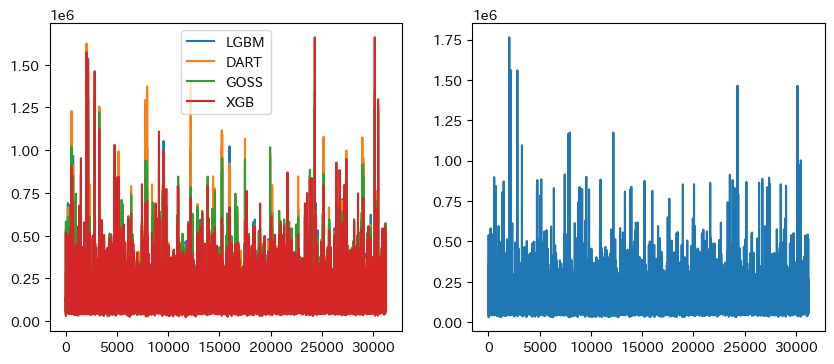

In [13]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(range(len(blend_pred)), pred_LGBM, label='LGBM')
ax.plot(range(len(blend_pred)), pred_DART, label='DART')
ax.plot(range(len(blend_pred)), pred_GOSS, label='GOSS')
ax.plot(range(len(blend_pred)), pred_XGB, label='XGB')

ax2.plot(range(len(blend_pred)), blend_pred)

ax.legend(loc='best')
plt.show()

In [14]:
predicts = pd.concat([pred_LGBM,pred_DART,pred_GOSS,pred_XGB],axis=1)
predicts.corr()

,0,0,0,0
0,1.00000,0.991690,0.989630,0.970660
0,0.99169,1.000000,0.986725,0.968464
0,0.98963,0.986725,1.000000,0.976114
0,0.97066,0.968464,0.976114,1.000000
